In [1]:
from datetime import datetime
import yaml
from backbone.utils.general_purpose import load_function
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation
from backbone.utils.wfo_utils import optimization_function, run_wfo
from backbone.utils.wfo_utils import run_strategy
import pandas as pd
import numpy as np


root = './backbone/data'

with open('configs/live_trading.yml', 'r') as file:
    strategies = yaml.safe_load(file)

with open('configs/test_creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

date_from = datetime(2020, 1, 1)
date_to = datetime(2024, 10, 22)

run = [
    'backbone.channel_strategy.Channel',
    'backbone.bbands_cross_strategy.BbandsCross',
    'backbone.mean_reversion_strategy.MeanReversion',
    'backbone.b_percent_strategy.BPercent',
    'backbone.day_per_week_strategy.DayPerWeek',
]

equity_curves = {}
trades = {}
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

bot_path = 'backbone.trader_bot.TraderBot'
performance = pd.DataFrame()

for strategy_name, configs in strategies.items():
    
    print(strategy_name)
    
    if strategy_name not in run:
        continue
    
    instruments_info = configs['instruments_info']
    wfo_params = configs['wfo_params']
    opt_params = configs['opt_params']
    name = configs['name']

    for ticker, info in instruments_info.items():
        cron = info['cron']
        timeframe = info['timeframe']
        
        print(strategy_name, ticker, timeframe)

        strategy = load_function(strategy_name)
        
        bot = load_function(bot_path)(name, ticker, timeframe, creds, opt_params, wfo_params, strategy)
    
        df = bot.get_data(date_from, date_to)
        
        configs = strategies[strategy_name]

        instruments_info = configs['instruments_info']
        wfo_params = configs['wfo_params']
        opt_params = configs['opt_params']

        _, _, optimized_params = run_wfo(
            strategy=bot.strategy,
            ticker=ticker,
            interval=timeframe,
            prices=df,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=bot.opt_params,
            lookback_bars=bot.wfo_params['look_back_bars'],
            warmup_bars=bot.wfo_params['warmup_bars'],
            validation_bars=250,
            plot=False
        )
        
        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=timeframe,
            commission=COMMISSION, 
            prices=df, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=optimized_params, 
            plot=False
        )

        
        equity_curves[bot.name] = stats['_equity_curve']
        trades[bot.name] = stats['_trades']
        
        mc, _, _ = montecarlo_statistics_simulation(
            equity_curve=equity_curves[bot.name],
            trade_history=trades[bot.name], 
            n_simulations=100_000, 
            initial_equity=INITIAL_CASH, 
            threshold_ruin=0.8, 
            return_raw_curves=True,
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        break
        
        performance = pd.concat([performance, df_stats])
        
performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

backbone.b_percent_strategy.BPercent
backbone.b_percent_strategy.BPercent IQm H1
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1000.0
  credit=0.0
  profit=0.0
  equity=1000.0
  margin=0.0
  margin_free=1000.0
  margin_level=0.0
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd
backbone.mean_reversion_strategy.MeanReversion
backbone.mean_reversion_strategy.MeanReversion UNHm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1000.0
  credit=0.0
  profit=0.0
  equity=1000.0
  margin=0.0
  margin_free=1000.0
  margin_level=0.

KeyError: 'return'

In [2]:
equity_curves.keys()

dict_keys(['BPercent_IQm_H1', 'BPercent_NTESm_H1', 'MeanRev_UNHm_H4', 'MeanRev_IQm_H2', 'DPW_VRTXm_H2', 'DPW_LLYm_H2', 'DPW_JPMm_H2', 'BbandsCross_SBUXm_H4', 'BbandsCross_BILIm_H2', 'BbandsCross_METAm_H4', 'Channel_AMZNm_H2', 'Channel_NVDAm_H2', 'Channel_USTECm_H4', 'Channel_XNGUSDm_H1'])

In [52]:
# Channel_AMZNm_H2 = equity_curves['Channel_AMZNm_H2']
# Channel_NVDAm_H2 = equity_curves['Channel_NVDAm_H2']
# Channel_XNGUSDm_H1 = equity_curves['Channel_XNGUSDm_H1']

# del equity_curves['Channel_AMZNm_H2']
# del equity_curves['Channel_NVDAm_H2'] 
# del equity_curves['Channel_XNGUSDm_H1']

# equity_curves['Channel_AMZNm_H2'] = Channel_AMZNm_H2
# equity_curves['Channel_NVDAm_H2'] = Channel_NVDAm_H2
# equity_curves['Channel_XNGUSDm_H1'] = Channel_XNGUSDm_H1

In [53]:
import pandas as pd

min_date = None
max_date = None

for name, curve in equity_curves.items():
    # Convertir las fechas a UTC si son tz-naive
    actual_date = curve.index[0].tz_localize('UTC') if curve.index[0].tz is None else curve.index[0].tz_convert('UTC')
    
    # Si min_date es None, inicializar con la primera fecha
    if min_date is None:
        min_date = actual_date
    # Comparar si la fecha actual es menor que min_date
    elif actual_date < min_date:
        min_date = actual_date

    # Si max_date es None, inicializar con la última fecha
    curve_last_date = curve.index[-1].tz_localize('UTC') if curve.index[-1].tz is None else curve.index[-1].tz_convert('UTC')
    
    if max_date is None:
        max_date = curve_last_date
    # Comparar si la fecha actual es mayor que max_date
    elif curve_last_date > max_date:
        max_date = curve_last_date

# Mostrar las fechas encontradas
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

# Calcular min_date y max_date
min_date = min_date.date()
max_date = max_date.date()

print(min_date)
print(max_date)

date_range = pd.to_datetime(pd.date_range(start=min_date, end=max_date, freq='D'))
print(date_range)

Min Date: 2020-01-02 00:00:00+00:00
Max Date: 2024-10-22 00:00:00+00:00
2020-01-02
2024-10-22
DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-10-13', '2024-10-14', '2024-10-15', '2024-10-16',
               '2024-10-17', '2024-10-18', '2024-10-19', '2024-10-20',
               '2024-10-21', '2024-10-22'],
              dtype='datetime64[ns]', length=1756, freq='D')


In [54]:
percentual_differences = {}

def get_percentual_differences(equity_curves, trades):
    for name, curve in equity_curves.items():
        # trade_df = trades[name]
        equity_df = equity_curves[name]
        
        
        # trade_df['ExitTime'] = trade_df['ExitTime'].dt.floor('D')
        
        # trade_df = pd.DataFrame(trade_df.groupby('ExitTime')['PnL'].sum()).reindex(date_range)
        # trade_df.fillna(0, inplace=True)
        
        equity_df = equity_df.reset_index().rename(columns={'index':'Date'})
        equity_df['Date'] = pd.to_datetime(equity_df['Date'])
        equity_df['Date'] = equity_df['Date'].dt.floor('D')
        
        equity_df = pd.DataFrame(equity_df.groupby('Date')['Equity'].last()).reindex(date_range)
        equity_df.ffill(inplace=True)
        equity_df.fillna(INITIAL_CASH, inplace=True)
  
        # pct_df = pd.merge(
        #     trade_df,
        #     equity_df,
        #     left_index=True,
        #     right_index=True
        # )

        equity_df['diff'] = equity_df['Equity'] - equity_df['Equity'].shift(1)
        
        percentual_differences[name] = equity_df
    
    return percentual_differences


differences = get_percentual_differences(equity_curves, trades)
differences

{'BPercent_IQm_H1':                   Equity  diff
 2020-01-02  10000.000000   NaN
 2020-01-03  10000.000000   0.0
 2020-01-04  10000.000000   0.0
 2020-01-05  10000.000000   0.0
 2020-01-06  10000.000000   0.0
 ...                  ...   ...
 2024-10-18  11522.989062   0.0
 2024-10-19  11522.989062   0.0
 2024-10-20  11522.989062   0.0
 2024-10-21  11522.989062   0.0
 2024-10-22  11522.989062   0.0
 
 [1756 rows x 2 columns],
 'BPercent_NTESm_H1':                   Equity  diff
 2020-01-02  10000.000000   NaN
 2020-01-03  10000.000000   0.0
 2020-01-04  10000.000000   0.0
 2020-01-05  10000.000000   0.0
 2020-01-06  10000.000000   0.0
 ...                  ...   ...
 2024-10-18  10988.524371   0.0
 2024-10-19  10988.524371   0.0
 2024-10-20  10988.524371   0.0
 2024-10-21  10988.524371   0.0
 2024-10-22  10988.524371   0.0
 
 [1756 rows x 2 columns],
 'MeanRev_UNHm_H4':                  Equity  diff
 2020-01-02  10000.00000   NaN
 2020-01-03  10000.00000   0.0
 2020-01-04  10000.00000

In [55]:

def get_hipotetical_wallet_equity(equity_curves, initial_equity):
    total = pd.DataFrame()
    variaciones_porcentuales = {}

    for name, curve in equity_curves.items():

        eq = equity_curves[name].copy()
        eq = eq.reset_index().rename(columns={'index':'Date'})[['Date','Equity']].sort_values(by='Date')
        eq['Date'] = pd.to_datetime(eq['Date'])
        eq['Date'] = eq['Date'].dt.floor('D')

        eq = eq.groupby('Date').agg({'Equity':'last'})

        eq = eq.reindex(date_range)
        
        eq.Equity = eq.Equity.ffill()
        eq.Equity = eq.Equity.fillna(INITIAL_CASH)
    
        eq['variacion'] = eq['Equity'] - eq['Equity'].shift(1)
        eq['variacion_porcentual'] = eq['variacion'] / eq['Equity'].shift(1)
        
        df_variacion = pd.DataFrame(
            {
                f'variacion_{name}': eq.variacion_porcentual.fillna(0)
            }
        )
        
        total = pd.concat([total, df_variacion], axis=1)

    total = total.reset_index().rename(columns={'index':'Date'})

    # Inicializa el valor de equity
    total['Equity'] = initial_equity

    # Lista de columnas con las variaciones porcentuales
    variation_cols = [col for col in total.columns if col.startswith('variacion')]

    # Calcular la curva de equity
    for i in range(1, len(total)):
        previous_equity = total.loc[i-1, 'Equity']  # Equity del periodo anterior
        
        # Calcula el impacto monetario de cada bot por separado y suma el resultado
        impact_sum = 0
        for col in variation_cols:
            variation = total.loc[i, col]
            impact_sum += previous_equity * variation
        
        # Actualiza el equity sumando el impacto monetario total
        total.loc[i, 'Equity'] = previous_equity + impact_sum

    # Resultado final

    total = total.set_index('Date')
    return total[['Equity']]

In [58]:
if 'variaciones_porcentuales' in equity_curves.keys():
    del equity_curves['variaciones_porcentuales']

initial_equity = 10000
total = get_hipotetical_wallet_equity(equity_curves=equity_curves, initial_equity=initial_equity)
equity_curves['variaciones_porcentuales'] = total


In [59]:
equity_curves.keys()

dict_keys(['BPercent_IQm_H1', 'BPercent_NTESm_H1', 'MeanRev_UNHm_H4', 'MeanRev_IQm_H2', 'DPW_VRTXm_H2', 'DPW_LLYm_H2', 'DPW_JPMm_H2', 'BbandsCross_SBUXm_H4', 'BbandsCross_BILIm_H2', 'BbandsCross_METAm_H4', 'Channel_USTECm_H4', 'Channel_AMZNm_H2', 'Channel_NVDAm_H2', 'variaciones_porcentuales'])

In [60]:
import plotly.graph_objects as go

# Crear una figura vacía
fig = go.Figure()

# Recorrer las curvas de equity de cada bot y agregarlas al gráfico
for k, v in equity_curves.items():
    
    fig.add_trace(go.Scatter(x=v.index, y=v.Equity, mode='lines', name=k))

# Actualizar los detalles del layout del gráfico
fig.update_layout(
    title="Curvas de Equity de Múltiples Bots",
    xaxis_title="Fecha",
    yaxis_title="Equity",
    legend_title="Bots"
)

# Mostrar el gráfico
fig.show()


In [61]:
import numpy as np

def max_drawdown(equity_curve):
    # Calcular el running max de la equity curve
    running_max = np.maximum.accumulate(equity_curve)
    
    # Calcular el drawdown
    drawdown = (equity_curve - running_max) / running_max
    
    # Encontrar el valor máximo de drawdown y la fecha correspondiente
    max_drawdown_value = np.min(drawdown) * 100  # Convertir el drawdown a porcentaje
    max_drawdown_date = equity_curve.index[np.argmin(drawdown)]
    
    print(f"Máximo drawdown: {max_drawdown_value:.2f}%")
    print(f"Fecha del máximo drawdown: {max_drawdown_date}")



for strategy, equity in equity_curves.items():
    print(strategy)
    max_drawdown(equity.Equity)
    print('=================================')

BPercent_IQm_H1
Máximo drawdown: -9.32%
Fecha del máximo drawdown: 2024-10-17 13:00:00
BPercent_NTESm_H1
Máximo drawdown: -7.23%
Fecha del máximo drawdown: 2024-10-11 11:00:00
MeanRev_UNHm_H4
Máximo drawdown: -6.32%
Fecha del máximo drawdown: 2024-09-04 16:00:00
MeanRev_IQm_H2
Máximo drawdown: -13.90%
Fecha del máximo drawdown: 2023-05-31 14:00:00
DPW_VRTXm_H2
Máximo drawdown: -2.92%
Fecha del máximo drawdown: 2022-12-19 14:00:00
DPW_LLYm_H2
Máximo drawdown: -8.07%
Fecha del máximo drawdown: 2024-01-03 20:00:00
DPW_JPMm_H2
Máximo drawdown: -4.08%
Fecha del máximo drawdown: 2022-10-20 18:00:00
BbandsCross_SBUXm_H4
Máximo drawdown: -1.16%
Fecha del máximo drawdown: 2024-06-17 16:00:00
BbandsCross_BILIm_H2
Máximo drawdown: -7.77%
Fecha del máximo drawdown: 2024-02-22 10:00:00
BbandsCross_METAm_H4
Máximo drawdown: -6.49%
Fecha del máximo drawdown: 2022-02-02 20:00:00
Channel_USTECm_H4
Máximo drawdown: -11.62%
Fecha del máximo drawdown: 2023-05-14 20:00:00
Channel_AMZNm_H2
Máximo drawdown: 

In [46]:
del equity_curves['variaciones_porcentuales']

KeyError: 'variaciones_porcentuales'

# Correlaciones

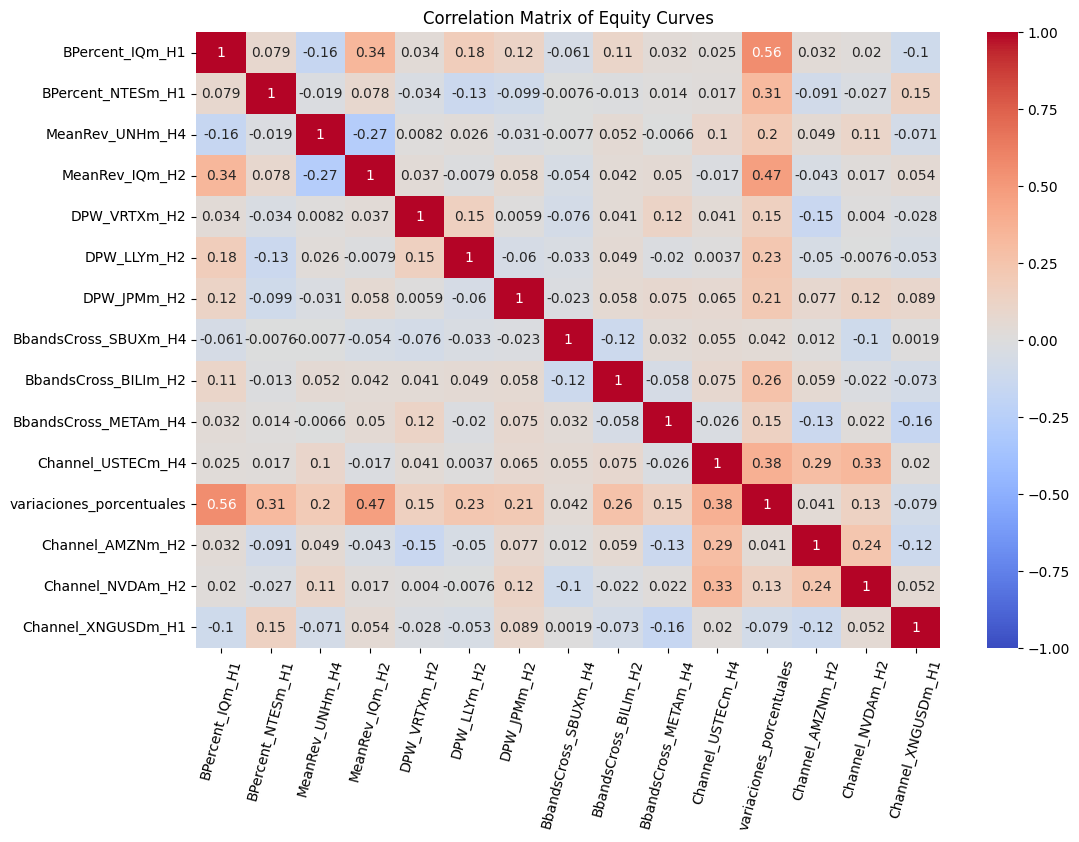

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in differences.items():
    all_equity_df[name] = df.resample('W').agg({'Equity':'last','diff':'sum',})['diff']


# Paso 2: Calcular la matriz de correlación

# all_equity_df = all_equity_df[['BPercent_IQm_H1','BPercent_NTESm_H1']]
correlation_matrix = all_equity_df.corr(method='pearson')

# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=75)
plt.show()

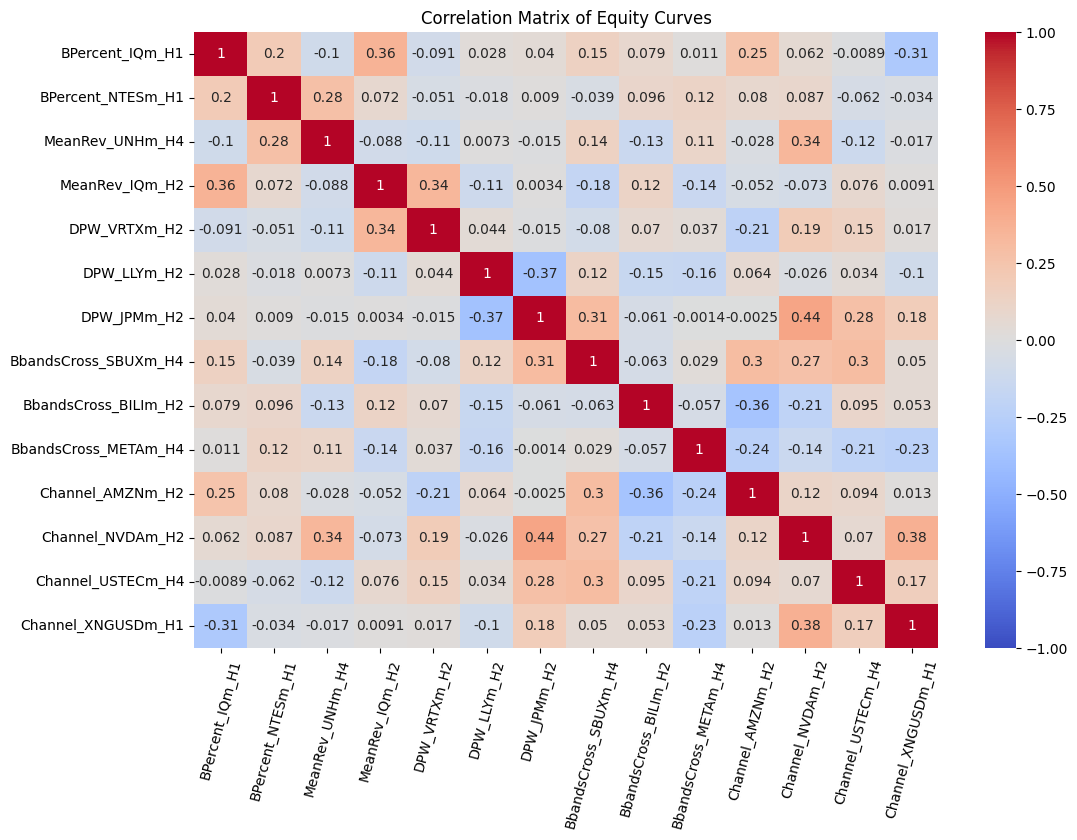

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in differences.items():
    all_equity_df[name] = df.resample('M').agg({'Equity':'last','diff':'sum',})['diff']


# Paso 2: Calcular la matriz de correlación

# all_equity_df = all_equity_df[['BPercent_IQm_H1','BPercent_NTESm_H1']]
correlation_matrix = all_equity_df.corr(method='pearson')

# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=75)
plt.show()

In [13]:
correlation_matrix

,BPercent_IQm_H1,BPercent_NTESm_H1,MeanRev_UNHm_H4,MeanRev_IQm_H2,DPW_VRTXm_H2,DPW_LLYm_H2,DPW_JPMm_H2,BbandsCross_SBUXm_H4,BbandsCross_BILIm_H2,BbandsCross_METAm_H4,Channel_AMZNm_H2,Channel_NVDAm_H2,Channel_USTECm_H4,Channel_XNGUSDm_H1
BPercent_IQm_H1,1.000000,0.198740,-0.100822,0.363219,-0.090809,0.027674,0.039608,0.147161,0.079252,0.010912,0.253116,0.062251,-0.008852,-0.306038
BPercent_NTESm_H1,0.198740,1.000000,0.280382,0.072000,-0.051001,-0.018483,0.008975,-0.039198,0.096045,0.121204,0.080244,0.086617,-0.061721,-0.034495
MeanRev_UNHm_H4,-0.100822,0.280382,1.000000,-0.088499,-0.105251,0.007304,-0.015298,0.137843,-0.133936,0.107450,-0.028242,0.340962,-0.119723,-0.016636
MeanRev_IQm_H2,0.363219,0.072000,-0.088499,1.000000,0.342357,-0.111703,0.003424,-0.177993,0.123814,-0.144579,-0.052264,-0.072658,0.075559,0.009091
DPW_VRTXm_H2,-0.090809,-0.051001,-0.105251,0.342357,1.000000,0.044247,-0.015255,-0.079599,0.069600,0.036748,-0.214276,0.192845,0.146100,0.017203
DPW_LLYm_H2,0.027674,-0.018483,0.007304,-0.111703,0.044247,1.000000,-0.373482,0.118594,-0.150984,-0.159143,0.063899,-0.025837,0.034172,-0.101080
DPW_JPMm_H2,0.039608,0.008975,-0.015298,0.003424,-0.015255,-0.373482,1.000000,0.308120,-0.060913,-0.001439,-0.002535,0.438380,0.278264,0.180674
BbandsCross_SBUXm_H4,0.147161,-0.039198,0.137843,-0.177993,-0.079599,0.118594,0.308120,1.000000,-0.063019,0.028896,0.304052,0.271505,0.303359,0.050355
BbandsCross_BILIm_H2,0.079252,0.096045,-0.133936,0.123814,0.069600,-0.150984,-0.060913,-0.063019,1.000000,-0.057198,-0.358643,-0.206116,0.094526,0.052715
BbandsCross_METAm_H4,0.010912,0.121204,0.107450,-0.144579,0.036748,-0.159143,-0.001439,0.028896,-0.057198,1.000000,-0.241713,-0.135320,-0.206417,-0.234190


In [14]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(all_equity_df.index, all_equity_df['profit'], color='skyblue', width=10)
plt.xlabel('Fecha')
plt.ylabel('Suma de la fila')
plt.title('Suma de cada fila a lo largo del tiempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'profit'

<Figure size 1000x600 with 0 Axes>

In [ ]:
non_corr = correlation_matrix[correlation_matrix<0.2]
non_corr


In [ ]:
(equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).std()

In [ ]:
all_equity_df.describe()

In [ ]:
summary = all_equity_df.describe()
mean_std = summary.loc['std'].mean()
mean_std

In [ ]:
summary.loc['std'].mean() / summary.loc['mean'].mean()

In [ ]:
(equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).std() / (equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).mean()

In [ ]:
uncorrelation_matrix = correlation_matrix[correlation_matrix < 0.6]
uncorrelation_matrix

In [ ]:
highcorrelation_matrix = correlation_matrix[correlation_matrix > 0.6]
highcorrelation_matrix

In [ ]:
a = [0.02, -0.01, 0.05, 0.03, -0.02]
b = [0.01, -0.02, 0.04, 0.01, -0.01]

pd.DataFrame({'a':a, 'b':b,}).corr()